In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow as tf

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Sequential

from tensorflow.keras import datasets
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras.layers import Input,Dense,Conv2D,MaxPooling2D,UpSampling2D,Flatten,Lambda,Reshape

from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

from keras import backend as K

The classes are:

| Label | Description |
|:-----:|-------------|
|   0   | T-shirt/top |
|   1   | Trouser     |
|   2   | Pullover    |
|   3   | Dress       |
|   4   | Coat        |
|   5   | Sandal      |
|   6   | Shirt       |
|   7   | Sneaker     |
|   8   | Bag         |
|   9   | Ankle boot  |

In [44]:
classes_dict = {
                0:"T-shirt/top",
                1:"Trouser",    
                2:"Pullover",   
                3:"Dress",     
                4:"Coat",       
                5:"Sandal",     
                6:"Shirt",      
                7:"Sneaker",    
                8:"Bag",        
                9:"Ankle boot"     
               }

### Loading Dataset

In [3]:
(X_train, y_train), (X_test, y_test) = datasets.fashion_mnist.load_data()

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
X_test.shape

(10000, 28, 28)

### Image shape

In [6]:
X_train[0].shape

(28, 28)

### Reshaping the image

In [7]:
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

### Normalising the image

In [8]:
X_train = X_train/255.0
X_test = X_test/255.0

In [9]:
def display_image(data,labels,indexes):

    # plot first few images
    plt.figure(figsize=(14,12))
    
    for i in range(len(indexes)):

        # Get image data
        img = data[indexes[i]]
        
        # Get text label
        text = labels[indexes[i]]
        classname = classes_dict[text] 
        
        # define subplot
        plt.subplot(330 + 1 + i)
        plt.title(classname,fontsize=10)
        # plot raw pixel data
        plt.imshow(img)

    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
    
    # show the figure
    plt.show()

### Visualise the images

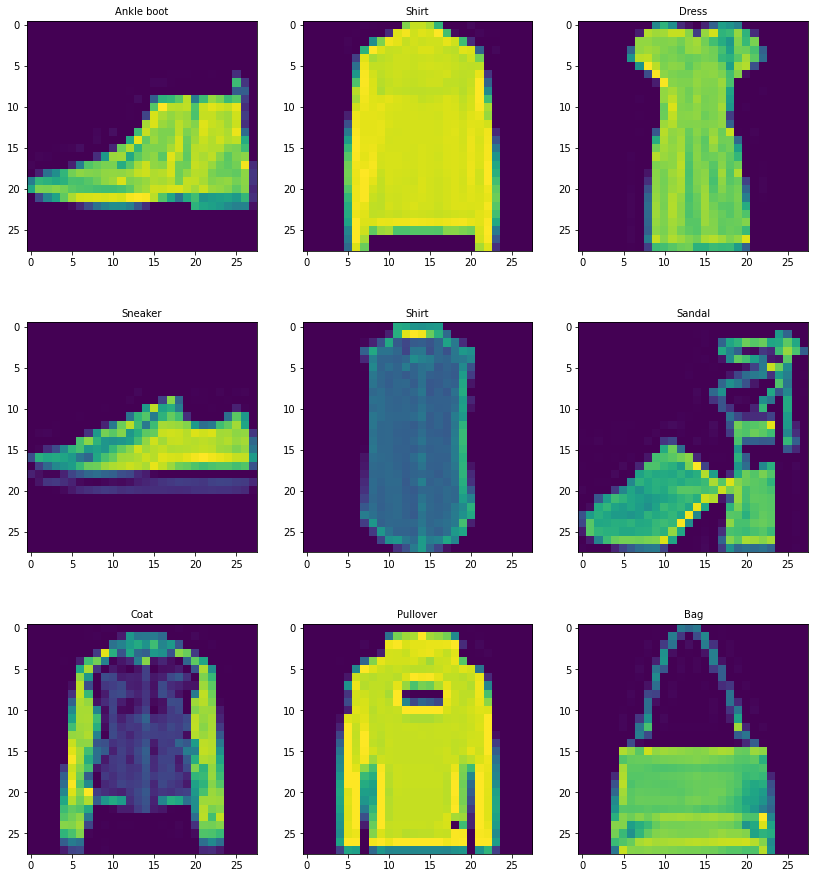

In [10]:
# plotting random images and their labels
no_of_images = 9 
indexes = [random.randint(0,len(X_train)) for i in range(no_of_images)]
display_image(X_train,y_train,indexes)

### Encoder

In [11]:
input_shape = X_train[0].shape

#input layers
encoder_input  = Input(shape=input_shape,name="Input Layer")

#hidden layer1
encoder_hidden = Conv2D(32,kernel_size=(2,2),strides=(1, 1),padding='same',name='Conv2D_1',activation='relu')(encoder_input)

#hidden layer2
encoder_hidden = MaxPooling2D(pool_size=(2, 2),name='Maxpool2D_1')(encoder_hidden)

#hidden layer3
encoder_hidden = Conv2D(16,kernel_size=(2,2),strides=(1, 1),padding='same',name='Conv2D_2',activation='relu')(encoder_hidden)

#hidden layer4
encoder_hidden = MaxPooling2D(pool_size=(2, 2),name='Maxpool2D_2')(encoder_hidden)

#hidden layer5
encoder_hidden = Conv2D(8,kernel_size=(2,2),strides=(1, 1),padding='same',name='Conv2D_3',activation='relu')(encoder_hidden)


conv_shape = K.int_shape(encoder_hidden)

#Flatten layer
encoder_flatten = Flatten()(encoder_hidden)


In [12]:
print("Convolutional shape",conv_shape)

Convolutional shape (None, 7, 7, 8)


## Latent Vectors Z_mu and Z_sigma

In [13]:
#mean and sigma layers are dense layers with dim = latent dimensions
Latent_dim = 2

z_mu = Dense(units=Latent_dim,name='Z_mean')(encoder_flatten)

z_sigma = Dense(units=Latent_dim,name='Z_sigma')(encoder_flatten)

### Reparametarisation trick for latent space generation using sampling

In [14]:
def sampling(args):
    
    z_mean,z_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    
    Z = z_mean + tf.exp(z_var*0.5)*epsilon
    
    return Z

In [15]:
latent_space = Lambda(function=sampling,name='Z_Layer')([z_mu,z_sigma])

In [16]:
encoder = Model(inputs = encoder_input, outputs = latent_space, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input Layer (InputLayer)    [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 Conv2D_1 (Conv2D)           (None, 28, 28, 32)           160       ['Input Layer[0][0]']         
                                                                                                  
 Maxpool2D_1 (MaxPooling2D)  (None, 14, 14, 32)           0         ['Conv2D_1[0][0]']            
                                                                                                  
 Conv2D_2 (Conv2D)           (None, 14, 14, 16)           2064      ['Maxpool2D_1[0][0]']         
                                                                                            

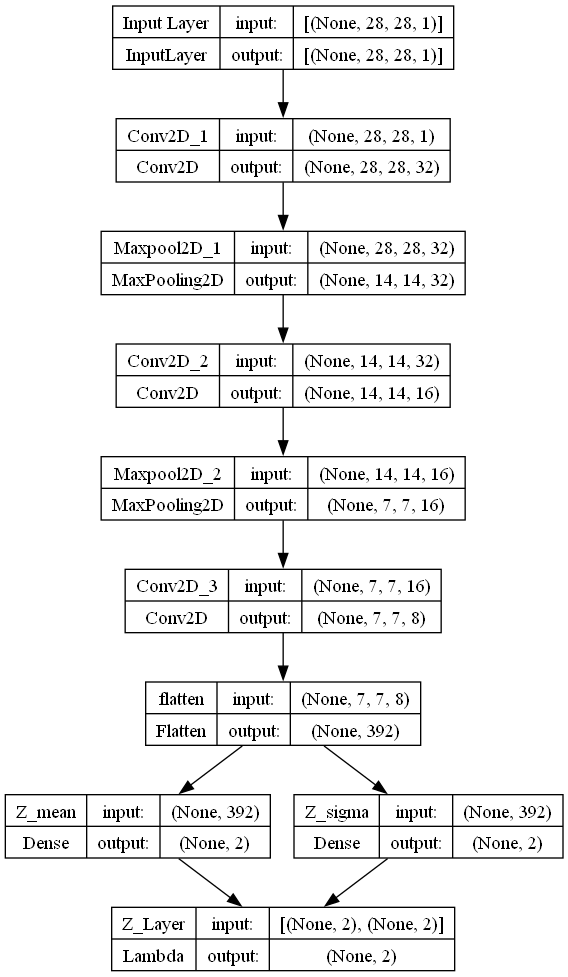

In [17]:
plot_model(encoder, to_file='encoder_architecture.png', show_shapes=True)

### Decoder

In [18]:
# Input Layer to decoder
decoder_input = Input(shape=(Latent_dim,))

# 1st hidden layer - Dense Layer
decoder_hidden = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(decoder_input)

# 2nd hidden layer - Reshape Layer
decoder_hidden = Reshape((conv_shape[1] , conv_shape[2] , conv_shape[3]))(decoder_hidden)

#hidden layer1
decoder_hidden = Conv2D(32,kernel_size=(2,2),strides=(1, 1),padding='same',name='Conv2D_4',activation='relu')(decoder_hidden)

#hidden layer2
decoder_hidden = UpSampling2D(size=(2, 2),name='Upsampling2D_1')(decoder_hidden)

#hidden layer3
decoder_hidden = Conv2D(16,kernel_size=(2,2),strides=(1, 1),padding='same',name='Conv2D_5',activation='relu')(decoder_hidden)

#hidden layer4
decoder_hidden = UpSampling2D(size=(2, 2),name='Upsampling2D_2')(decoder_hidden)

#hidden layer5
decoder_hidden = Conv2D(8,kernel_size=(2,2),strides=(1, 1),padding='same',name='Conv2D_6',activation='relu')(decoder_hidden)


#Flatten layer
decoder_output = Conv2D(filters=1,kernel_size=(2,2),padding='same',activation='relu',name='conv2d_7')(decoder_hidden)

In [19]:
decoder = Model(inputs = decoder_input, outputs = decoder_output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 392)               1176      
                                                                 
 reshape (Reshape)           (None, 7, 7, 8)           0         
                                                                 
 Conv2D_4 (Conv2D)           (None, 7, 7, 32)          1056      
                                                                 
 Upsampling2D_1 (UpSampling  (None, 14, 14, 32)        0         
 2D)                                                             
                                                                 
 Conv2D_5 (Conv2D)           (None, 14, 14, 16)        2064      
                                                           

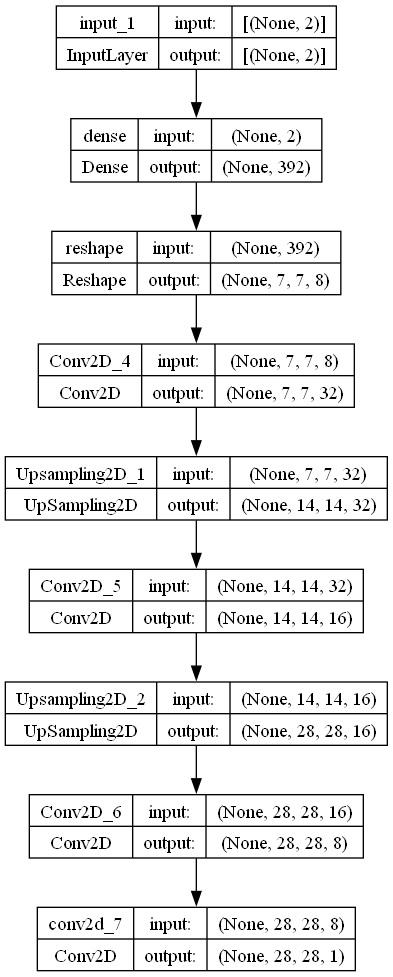

In [20]:
plot_model(decoder, to_file='decoder_architecture.png', show_shapes=True)

### combining encoder and decoder

In [21]:
# Output from encoder
encoder_output = encoder(encoder_input)

# Output from encoder (latent vector) becomes the input from decoder
decoder_output = decoder(encoder_output)

# Create a model with raw input as input and output from the decoder as output
vae = Model(encoder_input, decoder_output, name='vae')

vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 2)                 4316      
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         4849      
                                                                 
Total params: 9165 (35.80 KB)
Trainable params: 9165 (35.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
def vae_loss(input_image, output_image, zmean, zlog_var):
    
    reconstruction_loss_factor = 100
    reconstruction_loss = reconstruction_loss_factor * tf.reduce_mean(K.square(input_image-output_image), axis=[1, 2, 3]) # reconstruction loss
    kl_loss = -0.5 * K.sum(1.0 + zlog_var - K.square(zmean) - K.exp(zlog_var), axis=1) # reparameterization loss
    total_loss = reconstruction_loss + kl_loss

    return total_loss

vae.add_loss(vae_loss(encoder_input, decoder_output, z_mu, z_sigma))

In [23]:
# Compile the VAE model
vae.compile(optimizer=Adam())

no_of_epochs = 15
# Train the VAE
history = vae.fit(X_train, X_train, batch_size=128, epochs=no_of_epochs, validation_data=(X_test, X_test))

Epoch 1/15
469/469 [==============================] - 94s 190ms/step - loss: 7.8775 - val_loss: 6.7067
Epoch 2/15
469/469 [==============================] - 91s 193ms/step - loss: 6.6497 - val_loss: 6.5809
Epoch 3/15
469/469 [==============================] - 89s 190ms/step - loss: 6.5663 - val_loss: 6.4860
Epoch 4/15
469/469 [==============================] - 88s 188ms/step - loss: 6.5162 - val_loss: 6.5098
Epoch 5/15
469/469 [==============================] - 89s 189ms/step - loss: 6.5027 - val_loss: 6.4255
Epoch 6/15
469/469 [==============================] - 89s 189ms/step - loss: 6.4850 - val_loss: 6.4642
Epoch 7/15
469/469 [==============================] - 89s 189ms/step - loss: 6.4703 - val_loss: 6.4495
Epoch 8/15
469/469 [==============================] - 89s 190ms/step - loss: 6.4602 - val_loss: 6.4328
Epoch 9/15
469/469 [==============================] - 91s 194ms/step - loss: 6.4551 - val_loss: 6.4624
Epoch 10/15
469/469 [==============================] - 90s 191ms/step - l

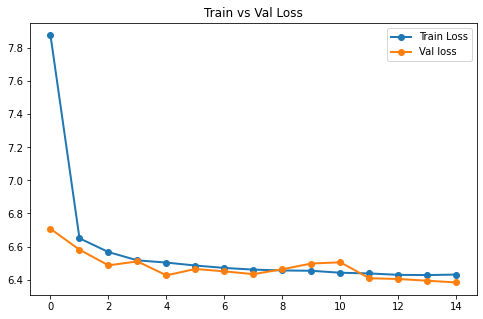

In [24]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

fig = plt.figure(figsize=(8,5))

plt.plot(list(range(no_of_epochs)),train_loss,marker='o',linewidth=2)
plt.plot(list(range(no_of_epochs)),val_loss,marker='o',linewidth=2)
plt.title("Train vs Val Loss")
plt.legend(["Train Loss", "Val loss"],loc = 'upper right')
plt.show()

### Save model

In [25]:
vae.save('vae.h5')

C:\Users\nswet\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### load model

### Predictions

In [28]:
vae_predictions = vae.predict(X_test)

313/313 [==============================] - 7s 19ms/step


In [29]:
vae_predictions.shape

(10000, 28, 28, 1)

In [30]:
vae_predictions[0].shape

(28, 28, 1)

In [56]:
def display_predictions(X_test,predictions,y_test,index):

    # plot first few images
    plt.figure(figsize=(10,2))
    
    

    # Get true image data
    img1 = X_test[index]

    # Get reconstructed image data
    img2 = predictions[index]

    # Get text label
    text = y_test[index]
    
    classname = classes_dict[text] 

    # define subplot
    plt.subplot(120 + 1 )
    plt.title(f"Orignal-{classname}",fontsize=10)
    # plot original img data
    plt.imshow(img1)

    plt.subplot(120 + 2)
    plt.title(f"Transformed-{classname}",fontsize=10)
    # plot original img data
    plt.imshow(img2)

    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
    
    # show the figure
    plt.show()
    

### Compare variation output and original

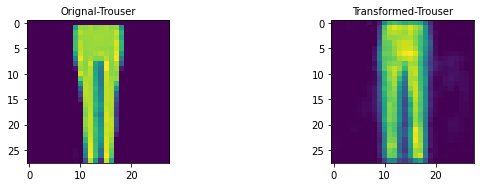

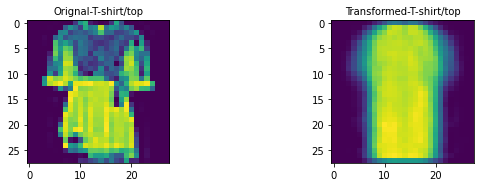

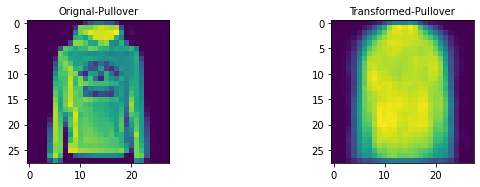

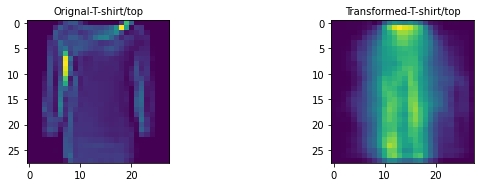

In [57]:
# plotting random images and their labels
no_of_images = 4 
indexes = [random.randint(0,len(X_test)) for i in range(no_of_images)]

for i in indexes:
    
    display_predictions(X_test,vae_predictions,y_test,i)

### Plotting the latent vector enocded by the encoder

313/313 [==============================] - 2s 7ms/step


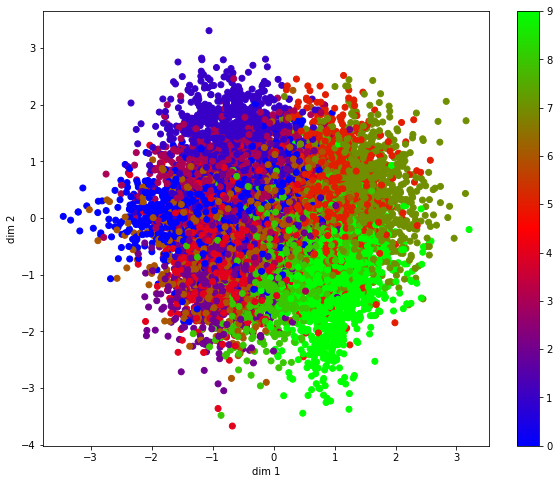

In [88]:
encoder_pred = encoder.predict(X_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 8))
plt.scatter(encoder_pred[:, 0], encoder_pred[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

In [63]:
encoder_pred

array([[ 1.0890639 , -0.17262818],
       [-1.2048377 , -1.7530053 ],
       [-1.0145785 ,  0.5086324 ],
       ...,
       [-0.39909363,  0.39192703],
       [-0.9559313 ,  1.5189129 ],
       [ 0.8274044 , -0.45591122]], dtype=float32)

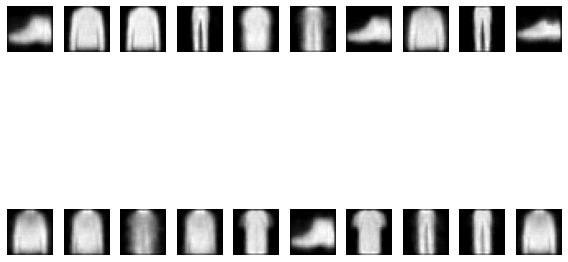

In [59]:
# Generate 50 random vectors
num_vectors = 20
latent_dim = 2  # Assuming a latent space dimension of 2
random_vectors = np.random.randn(num_vectors, latent_dim)
# (20,2)

# Generate images using the random vectors
generated_images = decoder(random_vectors)  # Assuming 'decoder' is the VAE decoder function

# Reshape the generated images if needed
generated_images = generated_images.numpy().reshape(num_vectors, 28, 28)

# Display the generated images

# Assuming 5 rows and 10 columns for display
fig, axes = plt.subplots(2, 10, figsize=(8, 8))  
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()


### [1,-3] represents green class 9 --> Ankle boot

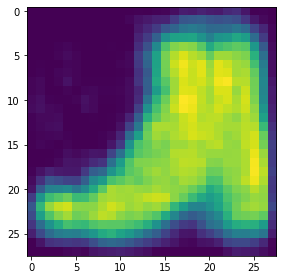

In [79]:

random_vectors = np.array([[1,-3]])
# Generate images using the random vectors
generated_images = decoder(random_vectors)  # Assuming 'decoder' is the VAE decoder function

# Reshape the generated images if needed
generated_images = generated_images.numpy().reshape(28, 28)

# Display the generated images

plt.imshow(generated_images)
plt.tight_layout()
plt.show()

### Predcition also looks like perefect ankle boot
### we shall start varying the vector to see how the variations in ankle boot look like

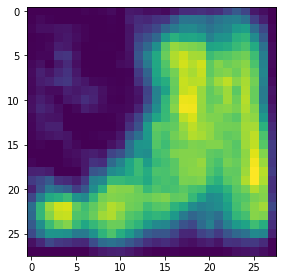

In [83]:
# [1,-5] represents green class 9 --> Ankle boot variations

random_vectors = np.array([[1,-5]])
# Generate images using the random vectors
generated_images = decoder(random_vectors)  # Assuming 'decoder' is the VAE decoder function

# Reshape the generated images if needed
generated_images = generated_images.numpy().reshape(28, 28)

# Display the generated images

plt.imshow(generated_images)
plt.tight_layout()
plt.show()

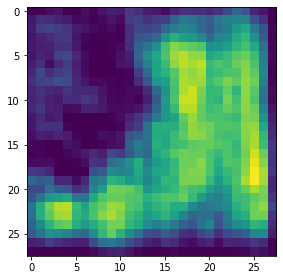

In [85]:
# [1,-7] represents green class 9 --> Ankle boot variations

random_vectors = np.array([[1,-7]])
# Generate images using the random vectors
generated_images = decoder(random_vectors)  # Assuming 'decoder' is the VAE decoder function

# Reshape the generated images if needed
generated_images = generated_images.numpy().reshape(28, 28)

# Display the generated images

plt.imshow(generated_images)
plt.tight_layout()
plt.show()

### noisy picture of ankle boot

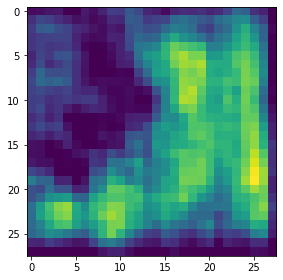

In [86]:
# [1,-10] represents green class 9 --> Ankle boot variations

random_vectors = np.array([[1,-10]])
# Generate images using the random vectors
generated_images = decoder(random_vectors)  # Assuming 'decoder' is the VAE decoder function

# Reshape the generated images if needed
generated_images = generated_images.numpy().reshape(28, 28)

# Display the generated images

plt.imshow(generated_images)
plt.tight_layout()
plt.show()

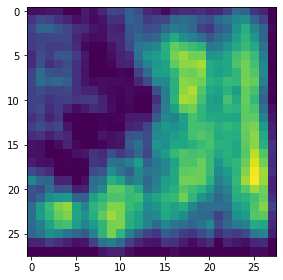

In [87]:
# [1,-11] represents green class 9 --> Ankle boot variations

random_vectors = np.array([[1,-11]])
# Generate images using the random vectors
generated_images = decoder(random_vectors)  # Assuming 'decoder' is the VAE decoder function

# Reshape the generated images if needed
generated_images = generated_images.numpy().reshape(28, 28)

# Display the generated images

plt.imshow(generated_images)
plt.tight_layout()
plt.show()